# Plot Figure 2

In [2]:
import lamindb as ln
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
sns.set_theme()
%config InlineBackend.figure_formats = ['svg']

In [8]:
results_df = pd.read_csv('Rjatd7RKmRnlzCd9Wrth.tsv', sep='\t', header=None)
results_df.columns = ["experiment", "epoch", "time"]
results_df

,experiment,epoch,time
0,h5py_sp,0,2.906638
1,h5py_sp,1,2.880476
2,h5py_sp,2,2.879070
3,h5py_sp,3,2.874755
4,h5py_sp_rand,0,6.321198
...,...,...,...
87,zarrV2tensorstore_dense_chunk,3,4.921915
88,zarrV2tensorstore_dense_chunk_rand,0,60.937075
89,zarrV2tensorstore_dense_chunk_rand,1,62.495638
90,zarrV2tensorstore_dense_chunk_rand,2,62.072053


In [9]:
results_df.experiment.unique()

array(['h5py_sp', 'h5py_sp_rand', 'soma_sp', 'soma_sp_rand', 'h5py_dense',
       'h5py_dense_rand', 'zarr_sp', 'zarr_sp_rand', 'zarr_dense',
       'zarr_dense_rand', 'zarr_dense_chunk', 'zarr_dense_chunk_rand',
       'parquet', 'parquet_rand', 'polars', 'parquet_chunk',
       'parquet_chunk_rand', 'arrow', 'arrow_chunk',
       'zarrV3tensorstore_dense_chunk',
       'zarrV3tensorstore_dense_chunk_rand',
       'zarrV2tensorstore_dense_chunk',
       'zarrV2tensorstore_dense_chunk_rand'], dtype=object)

We remove `parquet_rand`, because the benchmark isn't meaningful. Randomized sampling from parquet only works in combination with chunking, which is `parquet_chunk.`

In [33]:
df = results_df.loc[results_df.experiment != "parquet_rand"].copy()

def fix_categoricals(df, categorical="experiment"):
    """Is inplace."""
    df[['backend', 'config']] = df[categorical].str.split('_', n=1, expand=True)
    df.loc[df.backend == "polars", "backend"] = "polars (parquet)"
    df.loc[df.backend == "polars (parquet)", "config"] = "dense"
    df.loc[df[categorical] == "arrow", "config"] = "dense"
    df.loc[df[categorical] == "arrow_chunk", "config"] = "dense_chunk"
    df.loc[df[categorical] == "parquet", "config"] = "dense"
    df.loc[df[categorical] == "parquet_chunk", "config"] = "dense_chunk"
    df.loc[df[categorical] == "parquet_chunk_rand", "config"] = "dense_chunk_rand"
    df.backend = df.backend.str.replace("zarrV2tensorstore", "tensorstore (zarr v2)")
    df.backend = df.backend.str.replace("zarrV3tensorstore", "tensorstore (zarr v3)")
    df.backend = df.backend.str.replace("soma", "tiledbsoma")
    df.config = df.config.str.replace("sp", "sparse")
    df.backend = pd.Categorical(df.backend)

fix_categoricals(df)

df["samples_per_second"] = 142000 / df.time

df = pd.concat([ df, df['config'].str.extract(r'^(?P<layout>.*?)(?P<rand>_rand)?$') ], axis=1)
df['rand'] = ~df['rand'].isna()
df

,experiment,epoch,time,backend,config,samples_per_second,layout,rand
0,h5py_sp,0,2.906638,h5py,sparse,48853.695563,sparse,False
1,h5py_sp,1,2.880476,h5py,sparse,49297.411572,sparse,False
2,h5py_sp,2,2.879070,h5py,sparse,49321.480263,sparse,False
3,h5py_sp,3,2.874755,h5py,sparse,49395.518739,sparse,False
4,h5py_sp_rand,0,6.321198,h5py,sparse_rand,22464.096848,sparse,True
...,...,...,...,...,...,...,...,...
87,zarrV2tensorstore_dense_chunk,3,4.921915,tensorstore (zarr v2),dense_chunk,28850.560713,dense_chunk,False
88,zarrV2tensorstore_dense_chunk_rand,0,60.937075,tensorstore (zarr v2),dense_chunk_rand,2330.272669,dense_chunk,True
89,zarrV2tensorstore_dense_chunk_rand,1,62.495638,tensorstore (zarr v2),dense_chunk_rand,2272.158594,dense_chunk,True
90,zarrV2tensorstore_dense_chunk_rand,2,62.072053,tensorstore (zarr v2),dense_chunk_rand,2287.663989,dense_chunk,True


In [ ]:
df.merge(df_storage[[

In [28]:
import plotly.express as px
import plotly.graph_objects as go

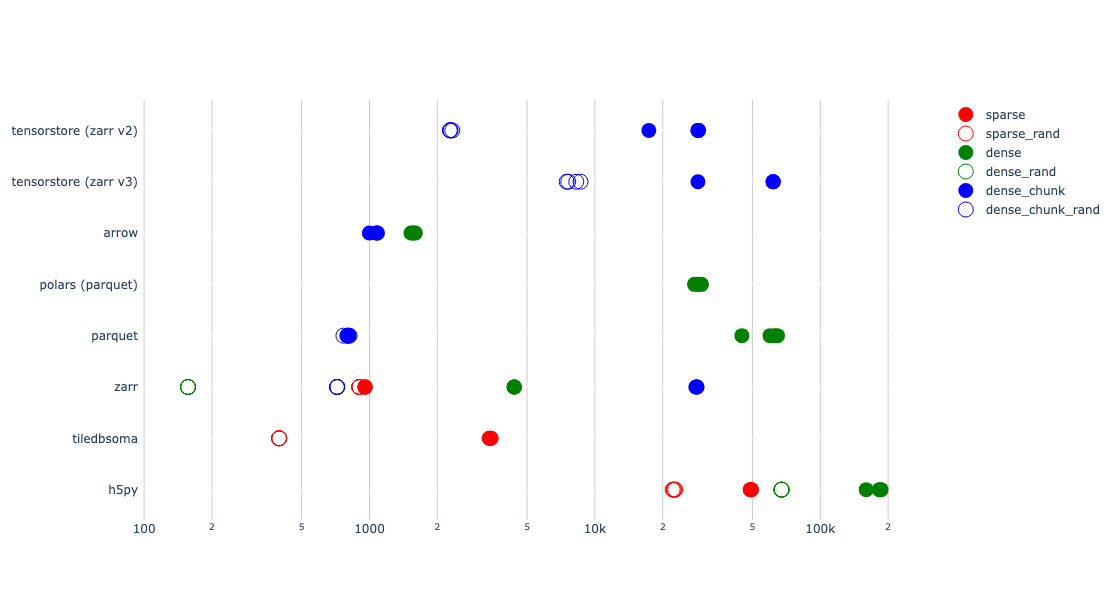

In [57]:
shapes = {
    'sparse': 'circle',
    'dense': 'square',
    'dense_chunk': 'diamond',
}
colors = {
    'sparse': 'red',
    'dense': 'green',
    'dense_chunk': 'blue',
}
fig = go.Figure()
for layout in [ 'sparse', 'dense', 'dense_chunk' ]:
    for rand in [ False, True ]:
        d = df[(df.layout == layout) & (df.rand == rand)]
        fig.add_trace(
            go.Scatter(
                name=f'{layout}' + (f'_rand' if rand else ''),
                mode='markers',
                x=d['samples_per_second'],
                y=d['backend'],
                marker_color=colors[layout],
                marker_symbol=d.apply(lambda r: 'circle' + ('-open' if r.rand else ''), axis=1),
                #marker_symbol=d.apply(lambda r: shapes[r.layout] + ('-open' if r.rand else ''), axis=1),
                marker_size=15,
            )
        )

fig.update_layout(
    height=600,
    plot_bgcolor='white',
    # paper_bgcolor='white',
    showlegend=True,
).update_xaxes(
    type="log",
    gridcolor='#ccc',
)
fig

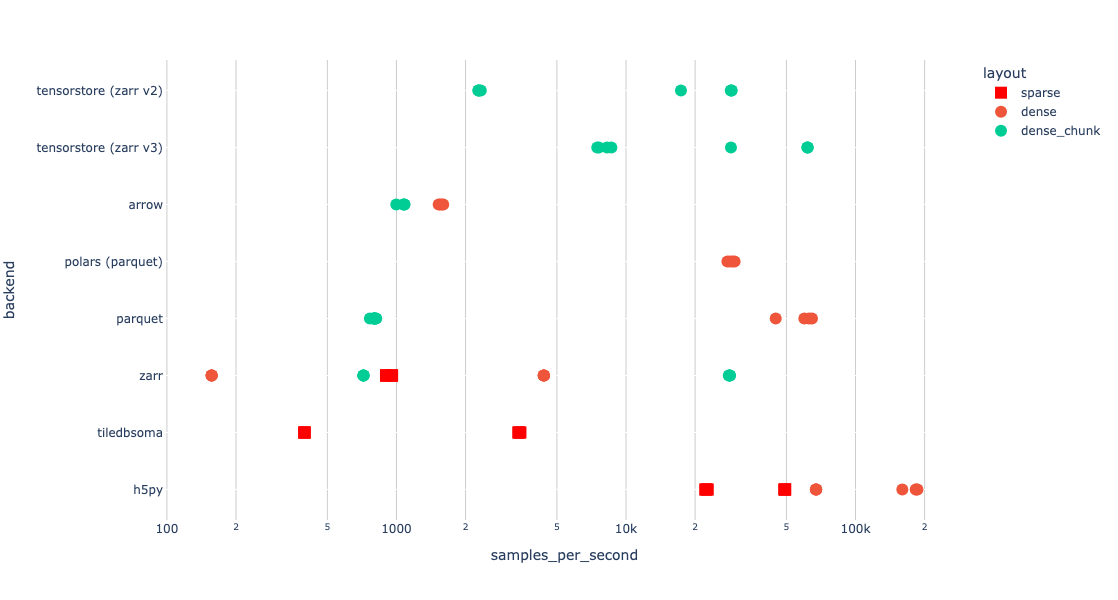

In [49]:
px.scatter(
    df,
    x='samples_per_second',
    y='backend',
    color='layout',
    log_x=True,
).update_layout(
    height=600,
    plot_bgcolor='white',
    #paper_bgcolor='white',
).update_xaxes(
    gridcolor='#ccc',
).update_traces(
    marker=dict(size=12),
).update_traces(
    marker=dict(color='red', symbol='square'), selector=dict(name='sparse')
)

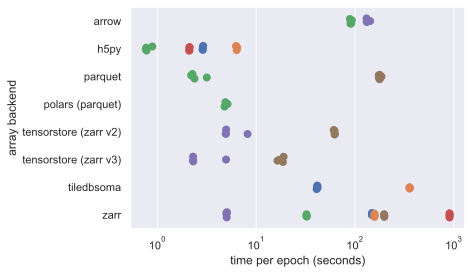

In [11]:
def plot_time(ax=None):
    if ax is None:
        plt.figure(figsize=(6, 4))    
    ax = sns.stripplot(x='time', y='backend', hue='config', data=df, size=8, ax=ax, legend=None)
    ax.set_xscale("log")
    ax.set_xlabel('time per epoch (seconds)')
    ax.set_ylabel('array backend')

plot_time()

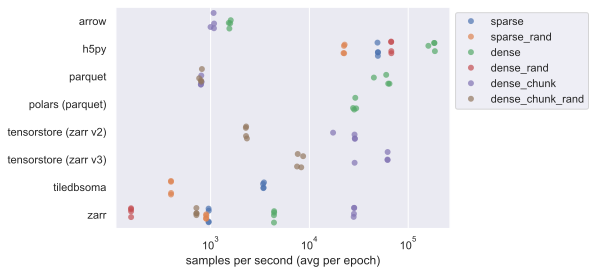

In [12]:
def plot_velocity(ax=None):
    if ax is None:
        plt.figure(figsize=(6, 4))
    ax = sns.stripplot(x='samples_per_second', y='backend', hue='config', data=df, size=6, alpha=0.7, jitter=0.3, ax=ax)
    ax.legend(title=None)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    ax.set_xscale("log")
    ax.set_xlabel('samples per second (avg per epoch)')
    ax.set_ylabel(None)

plot_velocity()

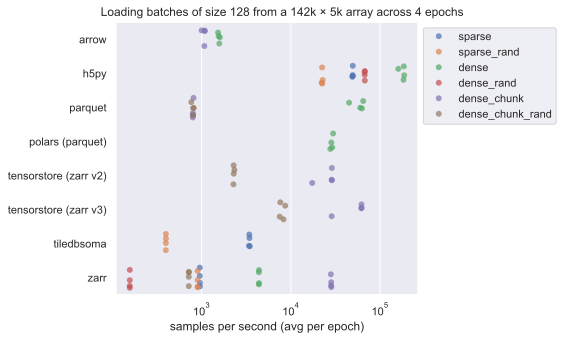

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
plot_velocity(ax)
plt.suptitle('Loading batches of size 128 from a 142k × 5k array across 4 epochs', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 1.04])

In [14]:
df_storage = pd.read_parquet('beun8jVU4A7CPRXl4fxz.parquet')
fix_categoricals(df_storage, categorical="storage")
df_storage

,storage,size,n_objects,backend,config
0,h5py_sp,0.363423,1,h5py,sparse
1,soma_sp,0.115801,290,tiledbsoma,sparse
2,h5py_dense,2.769480,1,h5py,dense
3,zarr_sp,0.178320,843,zarr,sparse
4,zarr_dense,0.547459,1606,zarr,dense
5,zarr_dense_chunk,0.527129,1698,zarr,dense_chunk
6,parquet,0.282000,1,parquet,dense
7,polars,0.282000,1,polars (parquet),dense
8,parquet_chunk,1.654349,1,parquet,dense_chunk
9,arrow,0.282000,1,arrow,dense


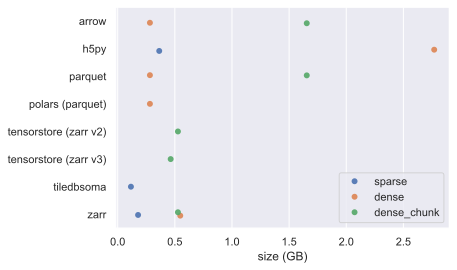

In [15]:
def plot_storage_size(ax=None):
    if ax is None:
        plt.figure(figsize=(6, 4))
    ax = sns.stripplot(x='size', y='backend', hue='config', data=df_storage, size=6, alpha=0.9, ax=ax)
    ax.legend(title=None)
    ax.set_xlabel('size (GB)')
    ax.set_ylabel(None)

plot_storage_size()

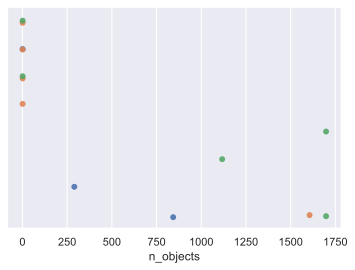

In [16]:
def plot_storage_n_objects(ax=None):
    if ax is None:
        plt.figure(figsize=(6, 4))
    ax = sns.stripplot(x='n_objects', y='backend', hue='config', data=df_storage, size=6, alpha=0.9, ax=ax, legend=False)
    # ax.legend(title=None)
    ax.set_ylabel(None)
    ax.set_yticks([])

plot_storage_n_objects()

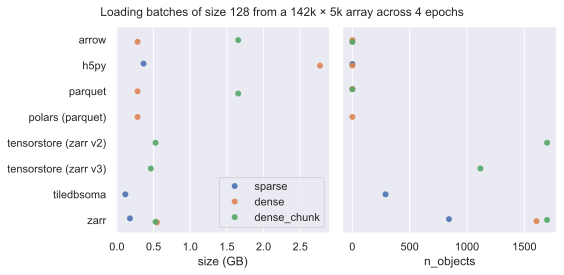

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
plot_storage_size(axs[0])
plot_storage_n_objects(axs[1])
plt.suptitle('Loading batches of size 128 from a 142k × 5k array across 4 epochs', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 1.04])